In [ ]:
## Machine Learning Project Image Generation Using GAN

## Importing the libraries

In [ ]:
!pip install torchinfo

In [ ]:
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torchvision.utils import make_grid

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Creating DCGAN Architechture

### Discriminator

In [ ]:
# discriminator

class Discriminator(nn.Module):
    def __init__(self,image_channels, dicriminator_features):
        super(Discriminator, self).__init__()


        self.disc = nn.Sequential(

            # INPUT SIZE : 64*64
            # initial Layer not Batch Norm
            nn.Conv2d( image_channels, discriminator_features, kernel_size=4, stride=2, padding=1 ),
            nn.LeakyReLU(0.2),

            # Size : 32*32
            # batch Norm convolution Layers
            self._block( discriminator_features, discriminator_features*2 , 4 ,2 ,1 ),

            # Size: 16*16
            self._block( discriminator_features*2, discriminator_features*4 , 4 ,2 ,1 ),

             # Size: 8*8
            self._block( discriminator_features*4, discriminator_features*8 , 4 ,2 ,1 ),

            # final Layer
            nn.Conv2d(discriminator_features*8, 1 , 4, 2, 0),
            # Output Size : 1*1
            nn.Sigmoid()

        )

     # return a convulational block with batchNorm and leak reLU activation
    def _block(self, in_channels,out_channels, kernel_size, stride, padding , bias=False):

        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=bias
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
    )

    def forward(self,x):
        return self.disc(x)

### Generator

In [ ]:
# Generator

class Generator(nn.Module):
    def __init__(self, z_dim, image_channels, generator_features):
        super(Generator, self).__init__()

        # Define the generator layers as an nn.Sequential
        self.gen = nn.Sequential(
            self._block(z_dim, generator_features * 16, 4, 1, 0),
            self._block(generator_features * 16, generator_features * 8, 4, 2, 1),
            self._block(generator_features * 8, generator_features * 4, 4, 2, 1),
            self._block(generator_features * 4, generator_features * 2, 4, 2, 1),
            nn.ConvTranspose2d(in_channels=generator_features * 2, out_channels=image_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding, bias=False):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=bias
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.gen(x)


### Weights intitializer

> prevents vanishing gradient problems

In [ ]:
def initialize_weights(model):
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d )):
            nn.init.normal_(module.weight.data,0,0.02)

## Hyper Parameters

In [ ]:
learning_rate = 2e-4
batch_size = 128
image_size = 64
image_channels = 3
z_dim = 100
num_epochs = 25
generator_features = 64
discriminator_features = 64

## Creating Data Loaders and Datasets

In [ ]:
image_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


In [ ]:
dataset = ImageFolder(root='/kaggle/input/celeba-dataset/img_align_celeba', transform=image_transforms)

In [ ]:
data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True )

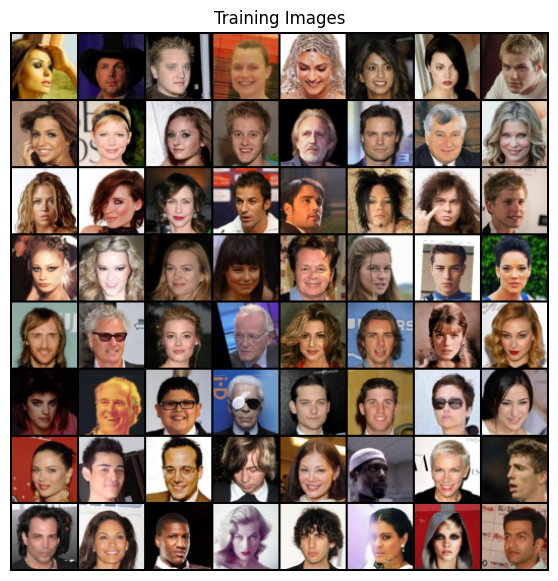

In [ ]:
real_batch = next(iter(data_loader))
plt.figure(figsize=(7,7))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Create Model Instances

In [ ]:
generator = Generator(z_dim,image_channels,generator_features).to(device)
discriminator = Discriminator(image_channels,discriminator_features).to(device)

In [ ]:
dummy_input = torch.randn(1, z_dim, 1, 1)

# Print the summary
summary(generator, input_size=dummy_input.shape)

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 3, 64, 64]            --
├─Sequential: 1-1                        [1, 3, 64, 64]            --
│    └─Sequential: 2-1                   [1, 1024, 4, 4]           --
│    │    └─ConvTranspose2d: 3-1         [1, 1024, 4, 4]           1,638,400
│    │    └─BatchNorm2d: 3-2             [1, 1024, 4, 4]           2,048
│    │    └─ReLU: 3-3                    [1, 1024, 4, 4]           --
│    └─Sequential: 2-2                   [1, 512, 8, 8]            --
│    │    └─ConvTranspose2d: 3-4         [1, 512, 8, 8]            8,388,608
│    │    └─BatchNorm2d: 3-5             [1, 512, 8, 8]            1,024
│    │    └─ReLU: 3-6                    [1, 512, 8, 8]            --
│    └─Sequential: 2-3                   [1, 256, 16, 16]          --
│    │    └─ConvTranspose2d: 3-7         [1, 256, 16, 16]          2,097,152
│    │    └─BatchNorm2d: 3-8             [1, 256, 16, 16] 

In [ ]:
dummy_input = torch.randn(1, image_channels, 64, 64)

# Print the summary
summary(discriminator, input_size=dummy_input.shape)

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1, 1, 1]              --
├─Sequential: 1-1                        [1, 1, 1, 1]              --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           3,136
│    └─LeakyReLU: 2-2                    [1, 64, 32, 32]           --
│    └─Sequential: 2-3                   [1, 128, 16, 16]          --
│    │    └─Conv2d: 3-1                  [1, 128, 16, 16]          131,072
│    │    └─BatchNorm2d: 3-2             [1, 128, 16, 16]          256
│    │    └─LeakyReLU: 3-3               [1, 128, 16, 16]          --
│    └─Sequential: 2-4                   [1, 256, 8, 8]            --
│    │    └─Conv2d: 3-4                  [1, 256, 8, 8]            524,288
│    │    └─BatchNorm2d: 3-5             [1, 256, 8, 8]            512
│    │    └─LeakyReLU: 3-6               [1, 256, 8, 8]            --
│    └─Sequential: 2-5                   [1, 512, 4, 4]            --


In [ ]:
# initialize weights
initialize_weights(generator)
initialize_weights(discriminator)

## Optimizers , Loss & Noise

In [ ]:
optimizer_generator = optim.Adam(params=generator.parameters(), lr=learning_rate , betas=(0.5,0.999) )
optimizer_discriminator = optim.Adam(params=discriminator.parameters(), lr=learning_rate , betas=(0.5,0.999) )

In [ ]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, z_dim, 1, 1).to(device)

## Training DCGAN

In [ ]:
generator.train()
discriminator.train()

for epoch in range(num_epochs):
    for batch_idx, (real_images, _) in enumerate(data_loader):
        real_images = real_images.to(device)

        ### Create noise tensor
        latent = torch.randn((batch_size, z_dim, 1, 1)).to(device)
        fake_images = generator(latent)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = discriminator(real_images).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = discriminator(fake_images.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2

        optimizer_discriminator.zero_grad()
        loss_disc.backward()
        optimizer_discriminator.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = discriminator(fake_images).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))

        optimizer_generator.zero_grad()
        loss_gen.backward()
        optimizer_generator.step()

        ### Print losses occasionally and show fake images
        if batch_idx % 50 == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(data_loader)} \
                Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )

Epoch [0/25] Batch 0/1583                 Loss D: 0.6923, loss G: 0.8130
Epoch [0/25] Batch 50/1583                 Loss D: 0.0548, loss G: 2.9011
Epoch [0/25] Batch 100/1583                 Loss D: 0.1436, loss G: 4.0515
Epoch [0/25] Batch 150/1583                 Loss D: 0.4627, loss G: 0.2728
Epoch [0/25] Batch 200/1583                 Loss D: 0.5598, loss G: 1.6988
Epoch [0/25] Batch 250/1583                 Loss D: 0.6121, loss G: 1.6048
Epoch [0/25] Batch 300/1583                 Loss D: 0.5884, loss G: 1.4973
Epoch [0/25] Batch 350/1583                 Loss D: 0.5752, loss G: 1.1239
Epoch [0/25] Batch 400/1583                 Loss D: 0.6524, loss G: 1.8361
Epoch [0/25] Batch 450/1583                 Loss D: 0.4809, loss G: 1.6008
Epoch [0/25] Batch 500/1583                 Loss D: 0.5690, loss G: 1.4204
Epoch [0/25] Batch 550/1583                 Loss D: 0.5875, loss G: 1.2669
Epoch [0/25] Batch 600/1583                 Loss D: 0.4525, loss G: 1.7924
Epoch [0/25] Batch 650/1583 

## Test DCGAN

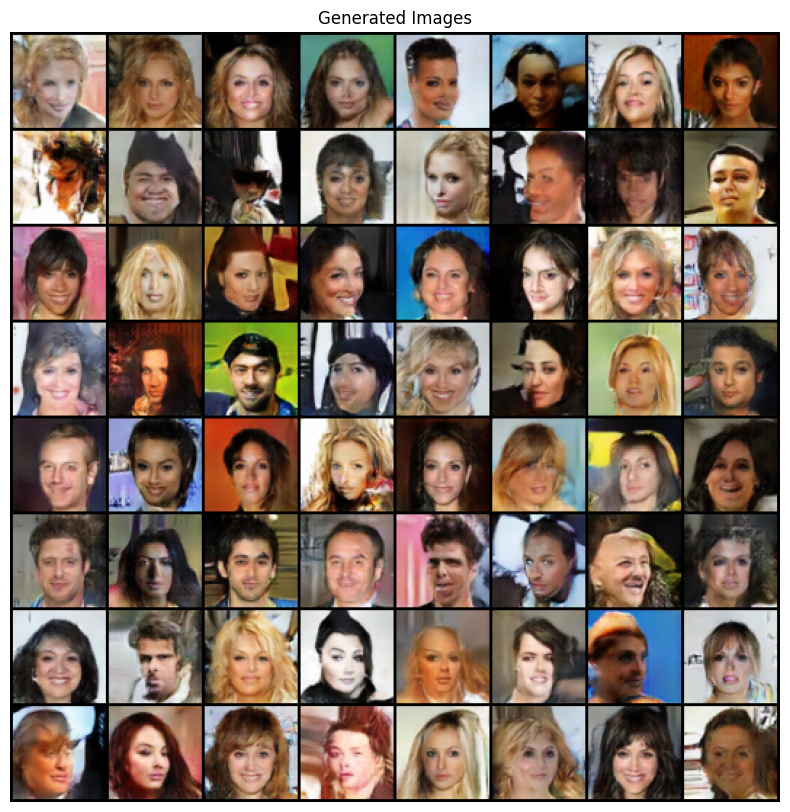

Generated images saved as 'generated_images.png'


In [ ]:
# At the end of your script, add the following code:

# Set the generator to evaluation mode
generator.eval()

# Number of images to generate
num_images = 64

# Generate random noise
z = torch.randn(num_images, z_dim, 1, 1).to(device)

# Generate fake images
with torch.no_grad():
    fake_images = generator(z)

# Create a grid of images using make_grid with normalize=True
img_grid = make_grid(fake_images.cpu(), nrow=8, padding=2, normalize=True)

# Convert to numpy array and transpose dimensions for plotting
img_grid_np = img_grid.permute(1, 2, 0).numpy()

# Plot the grid of generated images
plt.figure(figsize=(10, 10))
plt.imshow(img_grid_np)
plt.axis('off')
plt.title("Generated Images")
plt.show()

# Optionally, save the generated images
torchvision.utils.save_image(fake_images, "generated_images.png", nrow=8, normalize=True)
print("Generated images saved as 'generated_images.png'")